In [5]:
def checkParams(model_params):
    regulz_types = set(['None', 'BatchNorm', 'LayerNorm', 'SpLayerNorm', 
                        'WeightNorm', 'InstanceNorm', 'AdversNorm'])

    # check filters
    if canBeCastToList(model_params['filters']):
        if not isIterableOfInts(model_params['filters']):
            raise Exception('param "filters" must be LIST of INTEGERS')
    else:
        raise Exception('param "filters" must be ITERABLE')

    # check regularization type
    if not model_params['regulz_type'] in regulz_types:
        raise Exception(f'supported normalization types: {regulz_types}')
        
    # check pool factor
    if not canBeCastToInt(model_params['pool_factor']):
        raise Exception(f'"pool_factor" must be INTEGER or lossless cast to it')
        
    # check class number
    if not canBeCastToInt(model_params['classes_nb']):
        raise Exception(f'"classes_nb" must be INTEGER or lossless cast to it')
        
    # check input shape
    if canBeCastToList(model_params['input_shape']):
        if not len(list(model_params['input_shape'])) == 3:
            raise Exception('param "input_shape" LEN must be 3')
        if not isIterableOfInts(model_params['filters']):
            raise Exception('param "input_shape" must be LIST of INTEGERS')
    else:
        raise Exception('param "input_shape" must be ITERABLE')
        
    # check pool positions
    if canBeCastToList(model_params['pool_positions']):
        if not isIterableOfInts(model_params['pool_positions']):
            raise Exception('param "pool_positions" must be LIST of INTEGERS')
        if (model_params['pool_positions']) != sorted(model_params['pool_positions']):
            raise Exception('"pool_positions" must be SORTED by ascending')
    else:
        raise Exception('param "pool_positions" must be ITERABLE')
        
    # chekc ReLU slope
#     if not canBeCastToFloat(model_params['ReLU_slope']):
#         raise Exception(f'"ReLU_slope" must be FLOAT or can be cast to it')
#     if not model_params['ReLU_slope']>=0 and model_params['ReLU_slope']<1:
#         raise Exception(f'"ReLU_slope" must be GREATER or EQUAL than 0 and LOWER than 1')
        

1. берем VGG-like сеть (всегда glorot инициализация или подобное);
  - поседовательность фильтов - 2 n, 3 n, 4 n, 6 n, 8 n, 12 n, ...
2. примерно находим n такое, что сеть без какой-либо регуляризации переобучается, но для n / 2 уже нет;
  - т.е. найти примерно оптимальное n и взять ~1.5-2x больше.
3. натренировать сети со всеми перечисленными методами;
  - где это возможно, варьировать силу регуляризации (~5 точек);
  - если это невозможно (e.g., batch norm), то варьровать n.
4. Normalizations:
  - BatchNorm
  - SpatialLayerNorm
  - LayerNorm
  - AdversarialNorm
  - WeightNorm
  - Dropout?
5. построить график на подобии README.

In [6]:
import os
import sys
import random
import shutil
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer
from pytorch_lightning.metrics.classification import confusion_matrix
from pytorch_lightning.callbacks import ModelCheckpoint


LOGDIR = 'logs_tmp'
os.makedirs('./'+LOGDIR, exist_ok=True)

In [7]:
torchvision.datasets.CIFAR10('./data', train=True, download=True)
torchvision.datasets.CIFAR10('./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [8]:
def _kl_div_2d(p, q):
    # D_KL(P || Q)
    batch, chans, height, width = p.shape
    unsummed_kl = F.kl_div(
        q.view(batch * chans, height * width).log(),
        p.view(batch * chans, height * width),
        reduction='none',
    )
    kl_values = unsummed_kl.sum(-1).view(batch, chans)
    return kl_values


def _js_div_2d(p, q):
    # JSD(P || Q)
    m = 0.5 * (p + q)
    return 0.5 * _kl_div_2d(p, m) + 0.5 * _kl_div_2d(q, m)

# TODO: add this to the main module


def _reduce_loss(losses, reduction):
    if reduction == 'none':
        return losses
    else:
        return torch.mean(losses) if reduction == 'mean' else torch.sum(losses)


def js_div_loss_2d(
        input: torch.Tensor,
        target: torch.Tensor,
        reduction: str = 'mean'
):
    r"""Calculates the Jensen-Shannon divergence loss between heatmaps.

    Arguments:
        input (torch.Tensor): the input tensor.
        target (torch.Tensor): the target tensor.
        reduction (string, optional): Specifies the reduction to apply to the
          output: ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction
          will be applied, ``'mean'``: the sum of the output will be divided by
          the number of elements in the output, ``'sum'``: the output will be
          summed. Default: ``'mean'``.

    Shape:
        - Input: :math:`(B, N, H, W)`
        - Target: :math:`(B, N, H, W)`, same shape as the input
    """
    return _reduce_loss(_js_div_2d(target, input), reduction)

In [9]:
def canBeCastToList(x):
    try:
        list(x)
        return True
    except Exception as e:
        return False
    
def isIterableOfInts(x):
    try:
        x_new = [v for v in x if int(v) == v]
        if len(x) == len(x_new) and len(x) > 0:
            return True
        return False
    except Exception as e:
        return False
    
def canBeCastToInt(x):
    try:
        if int(x)==x:
            return True
        else:
            return False
    except Exception as e:
        return False
    
def canBeCastToFloat(x):
    try:
        float(x)
        return True
    except Exception as e:
        return False

In [7]:
# class AdversarialNorm2dshift(nn.Module):
#     def __init__(self, num_features, num_channels):
#         super().__init__()
#         self.bias = nn.Parameter(data=torch.zeros(num_channels))
#         self.scale = nn.Parameter(data=torch.ones(num_channels))
#         self.f_num = np.prod(num_features)
        
#         self.clf = nn.Sequential()
#         self.clf.add_module('lin', nn.Linear(self.f_num, self.f_num))
#         self.clf.add_module('lin_actv', nn.ReLU())
#         self.clf.add_module('clf', nn.Linear(self.f_num, 1))
        
        
#     def forward(self, x):
#         x_fake = x.clone()
#         # Use reparametrization trick (with predicting mean and scale)
#         x_fake = x_fake.view(x.shape[0]*x.shape[1], -1)
#         x_real = torch.randn(x_fake.shape).cuda()
        
#         real = torch.ones(x.shape[0]*x.shape[1]).cuda() * -1
#         fake = torch.ones(x.shape[0]*x.shape[1]).cuda()
        
#         y_true = torch.cat((real, fake))
#         x_all = torch.cat((x_real, x_fake))
#         y_pred = self.clf(x_all)
#         return x, y_true, y_pred


# class AdversarialNorm2d(nn.Module):
#     def __init__(self, num_features):
#         super().__init__()
#         self.f_num = np.prod(num_features)
        
#         # Like a InstanceNorm (HxW)
#         self.clf = nn.Sequential()
#         self.clf.add_module('lin', nn.Linear(self.f_num, self.f_num))
#         self.clf.add_module('lin_actv', nn.ReLU())
#         self.clf.add_module('clf', nn.Linear(self.f_num, 1))
        
#         # Like a SpLayerNorm (C)
#         # Note that conv 1x1 is a equal with linear
#         # Try to normalize each pixel
# #         self.clf = nn.Sequential()
# #         self.clf.add_module('conv', nn.Conv2d(self.f_num, self.f_num, 1))
# #         self.clf.add_module('conv_act', nn.ReLU())
# #         self.clf.add_module('clf', nn.Conv2d(self.f_num, 1, 1))
        
#         # Like a LayerNorm
#         # Try to normalize each batch (aggregate CHW)
#         # TODO (This is a not so very small network... Is it ok?)
# #         self.clf = nn.Sequential()
# #         self.clf.add_module('conv1', nn.Conv2d(self.f_num, self.f_num, 3))
# #         self.clf.add_module('conv1_act', nn.ReLU())
# #         self.clf.add_module('conv2', nn.Conv2d(self.f_num, self.f_num, 3))
# #         self.clf.add_module('conv2_act', nn.ReLU())
# #         self.clf.add_module('clf', nn.Conv2d(self.f_num, 1, 1))
        
        
#     def forward(self, x):
#         x_fake = x.clone()
#         x_fake = x_fake.view(x.shape[0]*x.shape[1], -1)
#         x_real = torch.randn(x_fake.shape).cuda()
        
#         real = torch.ones(x.shape[0]*x.shape[1]).cuda() * -1 ### shape??
#         fake = torch.ones(x.shape[0]*x.shape[1]).cuda()
        
#         y_true = torch.cat((real, fake))
#         x_all = torch.cat((x_real, x_fake))
#         y_pred = self.clf(x_all)
#         return x, y_true, y_pred
        

# class Adversarial_VGGLike(nn.Module):
#     def __init__(self, model_params):
#         super().__init__()
#         self.elu_alpha = model_params['elu_alpha']
        
#         self.conv1 = nn.Conv2d(3, model_params['filters'][0], kernel_size=(3,3), padding=(0,0), stride=(1,1))
#         self.conv2 = nn.Conv2d(model_params['filters'][0], model_params['filters'][1], kernel_size=(3,3), padding=(0,0), stride=(1,1))
#         self.conv3 = nn.Conv2d(model_params['filters'][1], model_params['filters'][2], kernel_size=(3,3), padding=(0,0), stride=(1,1))
#         self.conv4 = nn.Conv2d(model_params['filters'][2], model_params['filters'][3], kernel_size=(3,3), padding=(0,0), stride=(1,1))
#         self.conv5 = nn.Conv2d(model_params['filters'][3], model_params['filters'][4], kernel_size=(3,3), padding=(0,0), stride=(1,1))
#         self.conv6 = nn.Conv2d(model_params['filters'][4], model_params['filters'][5], kernel_size=(3,3), padding=(0,0), stride=(1,1))

#         self.adv_norm1 = AdversarialNorm2d((30,30))
#         self.adv_norm2 = AdversarialNorm2d((28,28))
#         self.adv_norm3 = AdversarialNorm2d((12,12))
#         self.adv_norm4 = AdversarialNorm2d((10,10))
        
        
#         self.clf = nn.Sequential()
#         self.clf.add_module(
#             'lin', nn.Linear(model_params['filters'][-1], model_params['filters'][-1])
#             )
#         self.clf.add_module(
#             'lin_actv',
#             nn.ELU(model_params['elu_alpha'])
#             )
#         self.clf.add_module(
#             'clf', nn.Linear(model_params['filters'][-1], model_params['classes_nb'])
#             )
    
    
#     def forward(self, x):
#         x, tr1, pr1 = self.adv_norm1(self.conv1(x))
#         x = F.elu(x, alpha=self.elu_alpha)
        
#         x, tr2, pr2 = self.adv_norm2(self.conv2(x))
#         x = F.elu(x, alpha=self.elu_alpha)
        
#         x = F.max_pool2d(x, 2)
        
#         x, tr3, pr3 = self.adv_norm3(self.conv3(x))
#         x = F.elu(x, alpha=self.elu_alpha)
        
#         x, tr4, pr4 = self.adv_norm4(self.conv4(x))
#         x = F.elu(x, alpha=self.elu_alpha)
        
#         x = F.max_pool2d(x, 2)
        
#         x = self.conv5(x)
#         x = F.elu(x, alpha=self.elu_alpha)
        
#         x = self.conv6(x)
#         x = F.elu(x, alpha=self.elu_alpha)
        
#         x = x.view(x.shape[0], -1)        
#         x = self.clf(x)
#         return x, [tr1,tr2,tr3,tr4], [pr1,pr2,pr3,pr4]

In [10]:
class WN_VGGLike(nn.Module):
    def __init__(self, model_params):
        super().__init__()

        pool_idx = 0
        block_idx = 0
        self.conv = nn.Sequential()
        prev_filt_size = model_params['input_shape'][0]
        for filt_size in model_params['filters']:
            self.conv.add_module(
                f'conv_{block_idx}',
                nn.utils.weight_norm(
                    nn.Conv2d(
                        prev_filt_size,
                        filt_size,
                        kernel_size=(3, 3),
                        padding=(0, 0),
                        stride=(1, 1)
                        )
                    )
                )
            self.conv.add_module(f'actv_{block_idx}', nn.ELU(model_params['elu_alpha']))
            block_idx += 1
            if pool_idx < len(model_params['pool_positions']):
                if block_idx == model_params['pool_positions'][pool_idx]:
                    self.conv.add_module(
                        f'maxpool_{block_idx}',
                        nn.MaxPool2d((model_params['pool_factor'], model_params['pool_factor']))
                        )
                    pool_idx += 1
                    block_idx += 1
            prev_filt_size = filt_size

        self.clf = nn.Sequential()
        self.clf.add_module(
            'lin',
            nn.utils.weight_norm(nn.Linear(model_params['filters'][-1], model_params['filters'][-1]))
            )
        self.clf.add_module(
            'lin_actv',
            nn.ELU(model_params['elu_alpha'])
            )
        self.clf.add_module(
            'clf',
            nn.utils.weight_norm(nn.Linear(model_params['filters'][-1], model_params['classes_nb']))
            )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.clf(x)
        return x

In [11]:
class InstanceBatchNorm2d(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features//2)
        self.inst = nn.InstanceNorm2d(num_features//2)
        
    def forward(self, x):
        x1 = self.bn(x[:,:self.num_features//2])
        x2 = self.inst(x[:,self.num_features//2:])
        return torch.cat((x1,x2), dim=1)

class BN_LN_IN_VGGLike(nn.Module):
    def __init__(self, model_params):
        super().__init__()

        pool_idx = 0
        block_idx = 0
        current_hw = 32
        self.conv = nn.Sequential()
        prev_filt_size = model_params['input_shape'][0]
        for i,filt_size in enumerate(model_params['filters']):
            self.conv.add_module(
                f'conv_{block_idx}',
                nn.Conv2d(
                    prev_filt_size,
                    filt_size,
                    kernel_size=(3, 3),
                    padding=(0, 0),
                    stride=(1, 1)
                    )
                )
            current_hw -= 2
            if i < 4:
                if model_params['regulz_type'] == 'BatchNorm':
                    self.conv.add_module(f'bn_{block_idx}', nn.BatchNorm2d(filt_size))
                if model_params['regulz_type'] == 'LayerNorm':
                    self.conv.add_module(f'ln_{block_idx}', nn.LayerNorm((
                        filt_size,
                        current_hw,
                        current_hw
                        )))

                if model_params['regulz_type'] == 'SpLayerNorm':
                    self.conv.add_module(f'sln_{block_idx}', nn.LayerNorm((current_hw, current_hw)))
                if model_params['regulz_type'] == 'InstanceNorm':
                    self.conv.add_module(f'ibn_{block_idx}', nn.InstanceNorm2d(filt_size))
                
            self.conv.add_module(f'actv_{block_idx}', nn.ELU(model_params['elu_alpha']))
    
            block_idx += 1
            if pool_idx < len(model_params['pool_positions']):
                if block_idx == model_params['pool_positions'][pool_idx]:
                    self.conv.add_module(
                        f'maxpool_{block_idx}',
                        nn.MaxPool2d((model_params['pool_factor'], model_params['pool_factor'])))
                    pool_idx += 1
                    block_idx += 1
                    current_hw *= 1/2
                    current_hw = int(current_hw)
            prev_filt_size = filt_size
            
        self.head = nn.Sequential()
        self.head.add_module(
            'lin',
            nn.Linear(model_params['filters'][-1], model_params['filters'][-1])
            )
        
        self.head.add_module(
            'lin_actv',
            nn.ELU(model_params['elu_alpha'])
            )
    
        self.head.add_module(
            'clf',
            nn.Linear(model_params['filters'][-1], model_params['classes_nb'])
            )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.head(x)
        return x

In [52]:
def conv2d_weight_init(x):
    if isinstance(x, nn.Conv2d):
        torch.nn.init.xavier_normal_(x.weight)
        torch.nn.init.zeros_(x.bias)

def linear_weight_init(x):
    if isinstance(x, nn.Linear):
        torch.nn.init.xavier_normal_(x.weight)
        torch.nn.init.zeros_(x.bias)

class VGGLike(pl.LightningModule):
    def __init__(self, model_params, pid=None, queue=None):
        super().__init__()
        self.history = {
            'train_loss': [],
            'train': {'loss':[], 'acc':[], 'adv_loss':[]},
            'val': {'loss':[], 'acc':[], 'adv_loss':[]}
        }

        self.seed = model_params['seed']
#         self.queue = queue
#         self.pid = pid
        self.model_params = model_params
        self.model = None
        self.configure_model()
        self.transform = transforms.Compose([
            transforms.ToTensor()])

        self.targets = []
        self.predicts = []
        self.confusion_matrix = torch.zeros(
            self.model_params['classes_nb'],
            self.model_params['classes_nb'], dtype=int
            )
        self.confusion_matrix_norm = torch.zeros(
            self.model_params['classes_nb'],
            self.model_params['classes_nb'], dtype=int
            )
        self.logpath = model_params['logpath']
        self.vis_dir = 'conf_matrix'
        self.ckpt_every_dir = 'every'

        os.makedirs(self.logpath+'/'+self.vis_dir, exist_ok=True)
        os.makedirs(self.logpath+'/checkpoints/'+self.ckpt_every_dir, exist_ok=True)

    def setSeeds(self):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all((self.seed+1)*2)
        np.random.seed((self.seed+2)*3)
        random.seed((self.seed+3)*4)

    def configure_model(self):
        if self.model_params['regulz_type'] in (
                'BatchNorm',
                'LayerNorm',
                'SpLayerNorm',
                'InstanceNorm',
                'None'
            ):
            self.model = BN_LN_IN_VGGLike(self.model_params)
        if self.model_params['regulz_type'] == 'WeightNorm':
            self.model = WN_VGGLike(self.model_params)
        if self.model_params['regulz_type'] == 'AdversarialNorm':
            self.model = Adversarial_VGGLike(self.model_params)

        self.setSeeds()
        self.model.apply(conv2d_weight_init)
        self.model.apply(linear_weight_init)

    def forward(self, x):
        return self.model(x)

    @pl.data_loader
    def train_dataloader(self):
        train_data = torchvision.datasets.CIFAR10(
            './data',
            train=True,
            transform=self.transform, 
            download=False
            )
        data_loader = DataLoader(
            train_data,
            batch_size=self.model_params['batch_size'],
            shuffle=True,
            num_workers=4
            )
        if self.seed:
            self.setSeeds()
        return data_loader

    @pl.data_loader
    def val_dataloader(self):
        val_data = torchvision.datasets.CIFAR10(
            './data',
            train=False,
            transform=self.transform,
            download=False
            )
        data_loader = DataLoader(
            val_data,
            batch_size=self.model_params['batch_size'],
            num_workers=4
            )
        return data_loader

    def calc_loss(self, logits, target):
        loss = F.cross_entropy(logits, target)
        return loss
    
    def calc_advloss(self, adv_tr, adv_pr):
        adv_loss = torch.zeros(1).cuda()
        for tr, pr in zip(adv_tr, adv_pr):
            adv_loss += (tr*F.tanh(pr)).mean()
        return self.model_params['lambd']*adv_loss

    def calc_confusion_matrix(self):
        targets = torch.cat(self.targets)
        preds = torch.cat(self.predicts)
        self.confusion_matrix = confusion_matrix(preds, targets).detach().cpu()

    def visualize_confustion_matrix(self, normalize=True):
        if normalize:
            self.confusion_matrix_norm = self.confusion_matrix/self.confusion_matrix.sum(dim=1)
        fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
        sns.heatmap(
            self.confusion_matrix_norm,
            ax=ax, cmap='Blues',
            vmin=0,
            vmax=1,
            annot=self.confusion_matrix.int(),
            fmt='d'
            )
        ax.set_xlabel('PREDICTED', fontsize=14)
        ax.set_ylabel('GROUND TRUTH', fontsize=14)
        ax.set_title(f'Epoch_{self.trainer.current_epoch}', fontsize=14)
        ax.set_xticklabels(self.model_params['classes'], rotation=65, fontsize=12)
        ax.set_yticklabels(self.model_params['classes'], rotation=0, fontsize=12)
        fig.savefig(
            self.logpath+'/'+self.vis_dir+f'/epoch_{self.trainer.current_epoch}.png',
            bbox_inches="tight"
            )
        plt.close('all')

    def save_model(self):
        path = self.trainer.logger.log_dir.split(os.path.sep)
        path.append('checkpoints')
        path.append(self.ckpt_every_dir)
        path = os.path.sep.join(path)
        self.trainer.save_checkpoint(path + f'/epoch={self.trainer.current_epoch}.ckpt')
        
        
    def configure_optimizers(self):
        optimizers = []
        optimizers.append(
            optim.Adam(
                self.model.conv1.parameters(),
                lr=5e-4,
                weight_decay=self.model_params['weight_decay']
            )
        )
        optimizers.append(
            optim.Adam(
                self.model.conv2.parameters(),
                lr=5e-4,
                weight_decay=self.model_params['weight_decay']
            )
        )
        return optimizers

        
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure, using_native_amp):
        # update generator opt every 4 steps
        if optimizer_idx == 0:
            if batch_idx % 4 == 0 :
                optimizer.step()
                optimizer.zero_grad()

        # update discriminator opt every 1 steps
        if optimizer_idx == 1:
            if batch_idx % 1 == 0 :
                optimizer.step()
                optimizer.zero_grad()

    def training_step(self, batch, batch_idx, optimizer_idx):
        image, target = batch
        if model_params['regulz_type'] == 'AdversarialNorm':
            if optimizer_idx == 0:
                logits = self.model(image, typeof_forward=0)
                loss = self.calc_loss(logits, target)
                
                metrics = {
                    'acc': (logits.max(dim=1)[1] == target).sum().float()/len(target)
                }
                outputs = {
                    'loss': loss,
                    'metrics': metrics
                }
                self.history['train_loss'].append(loss.item())
                
            if optimizer_idx == 1:
                tr, pr = self.model(image, typeof_forward=1)
                loss = self.calc_advloss(tr, pr)
                metrics = {
                    'acc': (logits.max(dim=1)[1] == target).sum().float()/len(target)
                }
                outputs = {
                    'loss': loss,
                    'metrics': metrics
                }
                self.history['adv_loss'].append(loss.item())
                
        else:
            logits = self.model(image)
            loss = self.calc_loss(logits, target)
            metrics = {
                'acc': (logits.max(dim=1)[1] == target).sum().float()/len(target)
            }
            outputs = {
                'loss': loss,
                'metrics': metrics
            }
            self.history['train_loss'].append(loss.item())
        return outputs

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs])
        avg_loss = loss.mean()
        self.history['train']['loss'].append(avg_loss.item())

        for metric in outputs[0]['metrics'].keys():
            metric_values = torch.stack([x['metrics'][metric] for x in outputs])
            avg_metric = metric_values.mean()
            self.history['train'][metric].append(avg_metric.item())
        return {
            'train_loss': avg_loss
        }

    def validation_step(self, batch, batch_idx):
        image, target = batch
        if model_params['regulz_type'] == 'AdversarialNorm':
            logits, tr, pr = self.model(image)
            loss = self.calc_advloss(logits, target, tr, pr)
        else:
            logits = self.model(image)
            loss = self.calc_loss(logits, target)
        class_preds = logits.max(dim=1)[1]

        self.predicts.append(class_preds)
        self.targets.append(target)

        metrics = {
            'acc': (class_preds == target).sum().float()/len(target)
        }
        outputs = {
            'loss': loss,
            'metrics': metrics
        }
        return outputs

    def validation_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs])
        avg_loss = loss.mean()
        self.history['val']['loss'].append(avg_loss.item())

#         self.save_model()
#         self.calc_confusion_matrix()
#         self.visualize_confustion_matrix(normalize=True)
        self.targets = []
        self.predicts = []

        
#         self.queue.put([self.pid, self.trainer.current_epoch])
        if self.trainer.current_epoch%50 == 0:
            print(self.trainer.current_epoch)

        for metric in outputs[0]['metrics'].keys():
            metric_values = torch.stack([x['metrics'][metric] for x in outputs])
            avg_metric = metric_values.mean()
            self.history['val'][metric].append(avg_metric.item())
        return {
            'val_loss': avg_loss,
            'val_acc': torch.FloatTensor([self.history['val']['acc'][-1]])
        }


In [2]:
def generate_filters(conv_layers_nb, filters_base, begin_factor=2):
    filters = [begin_factor*filters_base]
    interv = 2
    difference = 1
    factor = begin_factor
    for i in range(conv_layers_nb-1):
        if (i+1)%interv == 0 and i != 0:
            difference *= 2
        factor += difference
        filters.append(factor*filters_base)
    return filters

def generate_logname(model_params):
    logname = ''
    logname += 'fnb_' + str(len(model_params['filters'])) + '--'
    logname += 'fbase_' + str(int(model_params['filters'][0]/2)) + '--'
    logname += 'wdecay_' + str(model_params['weight_decay']) + '--'
    logname += 'elu_' + str(model_params['elu_alpha']) + '--'
    if model_params['regulz_type'] == 'WeightNorm':
        rname = 'WN_'
    if model_params['regulz_type'] == 'BatchNorm':
        rname = 'BN_' + str(model_params['batch_size'])
    if model_params['regulz_type'] == 'InstanceNorm':
        rname = 'IBN_'
    if model_params['regulz_type'] == 'LayerNorm':
        rname = 'LN_'
    if model_params['regulz_type'] == 'SpLayerNorm':
        rname = 'SLN_'
    if model_params['regulz_type'] == 'AdversarialNorm':
        rname = 'AN-'
        if model_params['advers_type'] == 'Layer':
            rname += model_params['advers_type'] + '_'
        rname += str(model_params['advers_f_num'])
    if model_params['regulz_type'] == 'None':
        rname = 'NONE_'
    logname += rname
    return logname
        
print(generate_filters(conv_layers_nb=6, filters_base=2, begin_factor=2))

[4, 6, 10, 14, 22, 30]


In [50]:
class AdversarialNorm2d(nn.Module):
    def __init__(self, num_features, model_params):
        super().__init__()
        self.f_num = np.prod(num_features)
        
        # Like a InstanceNorm (HxW)
#         self.clf = nn.Sequential()
#         self.clf.add_module('lin', nn.Linear(self.f_num, self.f_num))
#         self.clf.add_module('lin_actv', nn.ReLU())
#         self.clf.add_module('clf', nn.Linear(self.f_num, 1))
        
        # Like a SpLayerNorm (C)
        # Note that conv 1x1 is a equal with linear
        # Try to normalize each pixel
#         self.clf = nn.Sequential()
#         self.clf.add_module('conv', nn.Conv2d(self.f_num, self.f_num, 1))
#         self.clf.add_module('conv_act', nn.ReLU())
#         self.clf.add_module('clf', nn.Conv2d(self.f_num, 1, 1))
        
        # Like a LayerNorm
        # Try to normalize each batch (aggregate CHW)
        # TODO (This is a not so very small network... Is it ok?)
        self.clf = nn.Sequential()
        self.clf.add_module('conv1', nn.Conv2d(self.f_num, model_params['advers_f_num'], 3))
        self.clf.add_module('conv1_act', nn.ReLU())
        self.clf.add_module('conv2', nn.Conv2d(model_params['advers_f_num'], model_params['advers_f_num'], 3))
        self.clf.add_module('conv2_act', nn.ReLU())
        self.clf.add_module('pool', nn.AdaptiveAvgPool2d(1))
        self.head = nn.Linear(model_params['advers_f_num'], 1)
        
        
    def forward(self, x):
        x_fake = x.clone()
        x_real = torch.randn(x_fake.shape).cuda()
        
        y_real = torch.ones(x.shape[0]).cuda() * -1
        y_fake = torch.ones(x.shape[0]).cuda()
        
        y_true = torch.cat((y_real, y_fake))
        x_all = torch.cat((x_real, x_fake))
        y_pred = self.clf(x_all)
        y_pred = self.head(y_pred.squeeze(2).squeeze(2))
        return x, y_true, y_pred
        

class Adversarial_VGGLike(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.elu_alpha = model_params['elu_alpha']
        
        self.conv1 = nn.Conv2d(3, model_params['filters'][0], kernel_size=(3,3), padding=(0,0), stride=(1,1))
        self.conv2 = nn.Conv2d(model_params['filters'][0], model_params['filters'][1], kernel_size=(3,3), padding=(0,0), stride=(1,1))
        self.conv3 = nn.Conv2d(model_params['filters'][1], model_params['filters'][2], kernel_size=(3,3), padding=(0,0), stride=(1,1))
        self.conv4 = nn.Conv2d(model_params['filters'][2], model_params['filters'][3], kernel_size=(3,3), padding=(0,0), stride=(1,1))
        self.conv5 = nn.Conv2d(model_params['filters'][3], model_params['filters'][4], kernel_size=(3,3), padding=(0,0), stride=(1,1))
        self.conv6 = nn.Conv2d(model_params['filters'][4], model_params['filters'][5], kernel_size=(3,3), padding=(0,0), stride=(1,1))

        self.adv_norm1 = AdversarialNorm2d((8), model_params)
        self.adv_norm2 = AdversarialNorm2d((12), model_params)
        self.adv_norm3 = AdversarialNorm2d((20), model_params)
        self.adv_norm4 = AdversarialNorm2d((28), model_params)
        
        
        self.clf = nn.Sequential()
        self.clf.add_module(
            'lin', nn.Linear(model_params['filters'][-1], model_params['filters'][-1])
            )
        self.clf.add_module(
            'lin_actv',
            nn.ELU(model_params['elu_alpha'])
            )
        self.clf.add_module(
            'clf', nn.Linear(model_params['filters'][-1], model_params['classes_nb'])
            )
    
    
    def forward(self, x, typeof_forward=0):
        """
            typeof_forward (int): 
                0 - forward without adversarial
                1 - forward only adversarial
                2 - forward everything
            
        """
        if typeof_forward == 0:
            x = F.elu(self.conv1(x), alpha=self.elu_alpha)
            x = F.elu(self.conv2(x), alpha=self.elu_alpha)
            x = F.max_pool2d(x, 2)
            x = F.elu(self.conv3(x), alpha=self.elu_alpha)
            x = F.elu(self.conv4(x), alpha=self.elu_alpha)
            x = F.max_pool2d(x, 2)
            x = F.elu(self.conv5(x), alpha=self.elu_alpha)
            x = F.elu(self.conv6(x), alpha=self.elu_alpha)
            x = x.view(x.shape[0], -1)        
            x = self.clf(x)
            
            return x
        
        elif typeof_forward == 1:
            x, tr1, pr1 = self.adv_norm1(self.conv1(x))
            x = F.elu(x, alpha=self.elu_alpha)

            x, tr2, pr2 = self.adv_norm2(self.conv2(x))
            x = F.elu(x, alpha=self.elu_alpha)

            x = F.max_pool2d(x, 2)

            x, tr3, pr3 = self.adv_norm3(self.conv3(x))
            x = F.elu(x, alpha=self.elu_alpha)

            x, tr4, pr4 = self.adv_norm4(self.conv4(x))
            x = F.elu(x, alpha=self.elu_alpha)
            
            return [tr1,tr2,tr3,tr4], [pr1,pr2,pr3,pr4]
            
        elif typeof_forward == 2:
            x, tr1, pr1 = self.adv_norm1(self.conv1(x))
            x = F.elu(x, alpha=self.elu_alpha)

            x, tr2, pr2 = self.adv_norm2(self.conv2(x))
            x = F.elu(x, alpha=self.elu_alpha)

            x = F.max_pool2d(x, 2)

            x, tr3, pr3 = self.adv_norm3(self.conv3(x))
            x = F.elu(x, alpha=self.elu_alpha)

            x, tr4, pr4 = self.adv_norm4(self.conv4(x))
            x = F.elu(x, alpha=self.elu_alpha)

            x = F.max_pool2d(x, 2)

            x = self.conv5(x)
            x = F.elu(x, alpha=self.elu_alpha)

            x = self.conv6(x)
            x = F.elu(x, alpha=self.elu_alpha)

            x = x.view(x.shape[0], -1)        
            x = self.clf(x)
            
            return x, [tr1,tr2,tr3,tr4], [pr1,pr2,pr3,pr4]

In [51]:
# %%time

classes =[
     'airplane',
     'automobile',
     'bird',
     'cat',
     'deer',
     'dog',
     'frog',
     'horse',
     'ship',
     'truck'
]

# model params
model_params = {
    'filters': [8, 12, 20, 28, 44, 60],
    'pool_positions': [2, 5], # indexing start from 0
    'regulz_type': 'AdversarialNorm',
    'pool_factor': 2,
    'classes': classes,
    'classes_nb': 10,
    'input_shape': [3, 32, 32], # [C, H, W],
    'elu_alpha': 0.1,
    'lambd': 1,
    'weight_decay': 0,
    'seed': 42,
    'batch_size': 256,
    'advers_f_num': 32,
    'advers_type': 'Layer'
}

LOGDIR = 'test_log'

# recreate log directory
logname = generate_logname(model_params)
logpath = './'+LOGDIR+'/'+logname
if os.path.exists(logpath):
    shutil.rmtree(logpath)
os.makedirs(logpath, exist_ok=True)
model_params['logpath'] = logpath

# model initialize
model = VGGLike(model_params)

os.makedirs(logpath+'/checkpoints/best/', exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=logpath+'/checkpoints/best/',
    save_top_k=1,
    verbose=False,
    monitor='val_acc',
    mode='max',
    prefix=''
)

# model training
tb_logger = pl_loggers.TensorBoardLogger(LOGDIR, name=logname, version='')
trainer = Trainer(logger=tb_logger, 
                  gpus=1, 
                  max_epochs=10,
                  checkpoint_callback=checkpoint_callback,
                  num_sanity_val_steps=0,
                  weights_summary=None,
                  progress_bar_refresh_rate=5
                 )
trainer.fit(model)

# save history
# pd.DataFrame(model.history['train_loss'], columns=['train_loss']).to_csv(logpath+'/train_loss.csv', index=False)
# pd.DataFrame(model.history['train']).to_csv(logpath+'/train.csv', index=False)
# pd.DataFrame(model.history['val']).to_csv(logpath+'/val.csv', index=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


C:\Users\Admin\miniconda3\envs\default\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


UnboundLocalError: local variable 'logits' referenced before assignment

In [185]:
train_data = torchvision.datasets.CIFAR10(
            './data',
            train=False, 
            download=False
            )

In [169]:
k = torch.randint(0, 1000, (1,))
t = transforms.Compose([
    transforms.ToTensor()])
a = t(train_data.data[k])

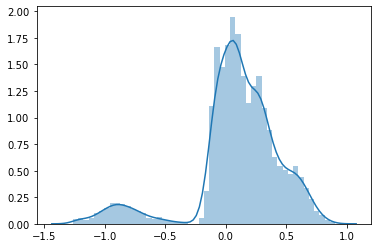

In [170]:
o = model.model.conv2(F.elu(model.model.conv1(a.unsqueeze(0))))
sns.distplot(o[0].detach().cpu().flatten())

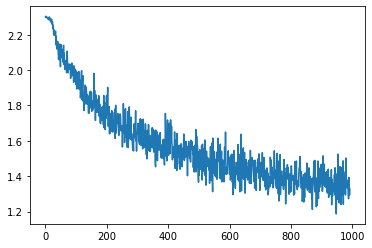

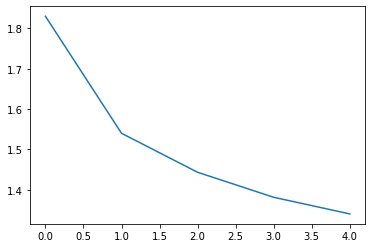

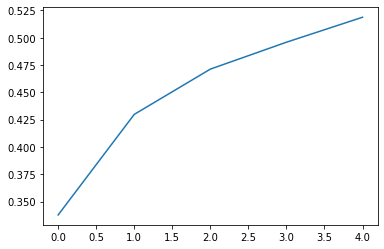

In [157]:
plt.plot(model.history['train_loss'])
plt.figure()
plt.plot(model.history['val']['loss'])
plt.figure()
plt.plot(model.history['val']['acc'])

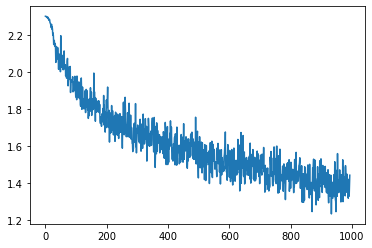

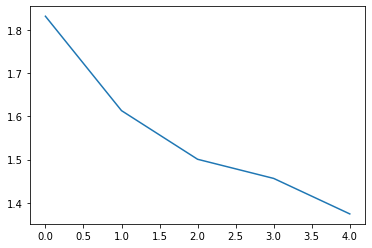

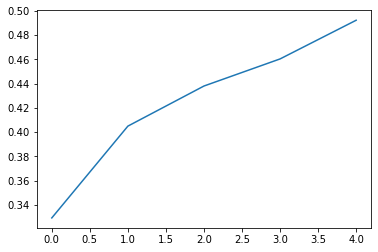

In [94]:
plt.plot(model.history['train_loss'])
plt.figure()
plt.plot(model.history['val']['loss'])
plt.figure()
plt.plot(model.history['val']['acc'])

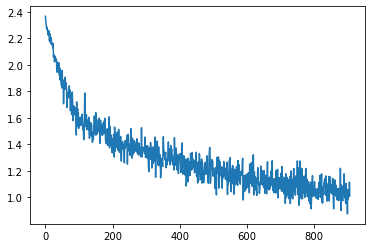

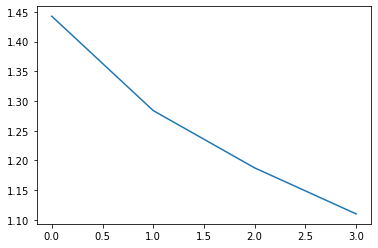

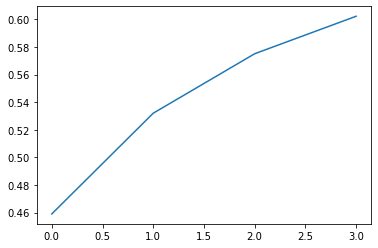

In [32]:
plt.plot(model.history['train_loss'])
plt.figure()
plt.plot(model.history['val']['loss'])
plt.figure()
plt.plot(model.history['val']['acc'])

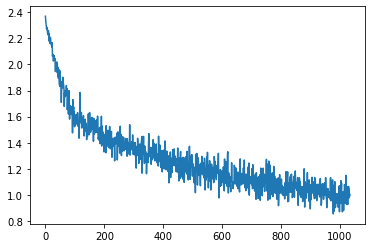

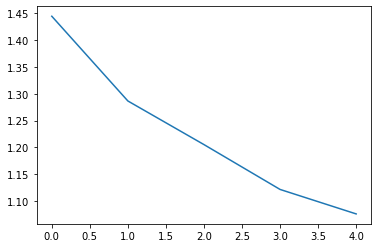

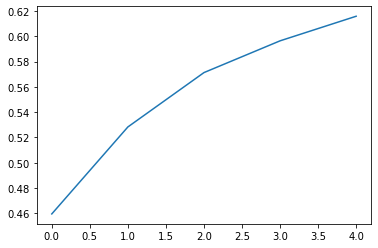

In [175]:
plt.plot(model.history['train_loss'])
plt.figure()
plt.plot(model.history['val']['loss'])
plt.figure()
plt.plot(model.history['val']['acc'])

In [44]:
val_data = torchvision.datasets.CIFAR10('./data', train=False)

[Text(0, 0.5, 'airplane'),
 Text(0, 1.5, 'automobile'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

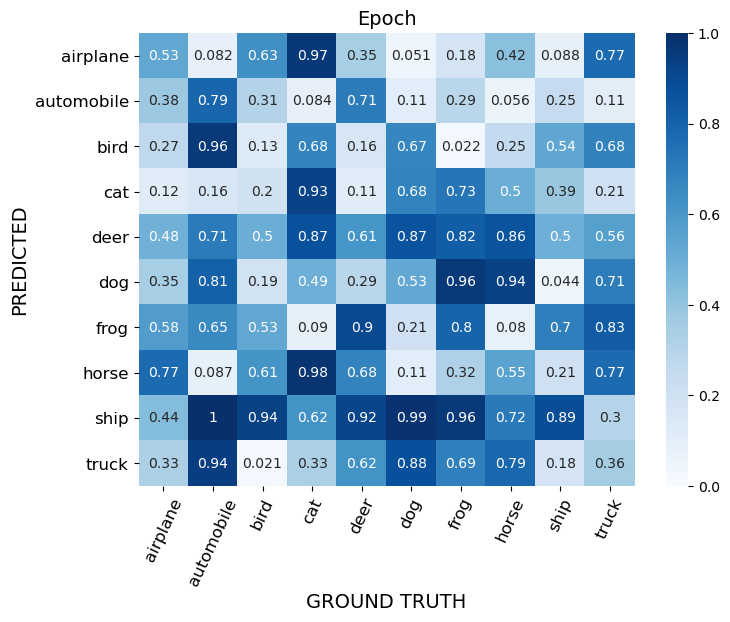

In [46]:
cnf = torch.rand(10,10)
cnf /= cnf.max()
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.heatmap(cnf, ax=ax, cmap='Blues', vmin=0, vmax=1, annot = cnf)
ax.set_ylabel('PREDICTED', fontsize=14)
ax.set_xlabel('GROUND TRUTH', fontsize=14)
ax.set_title(f'Epoch', fontsize=14)
ax.set_xticklabels(val_data.classes, rotation=65, fontsize=12)
ax.set_yticklabels(val_data.classes, rotation=0, fontsize=12)
# ax.set_xticks(val_data.classes, rotation=90)

In [69]:
for i in range(200):
    cnf = torch.rand(10,10)
    cnf /= cnf.max()
    fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    sns.heatmap(cnf, ax=ax, cmap='Blues', vmin=0, vmax=1)
    ax.set_ylabel('PREDICTED', fontsize=14)
    ax.set_xlabel('GROUND TRUTH', fontsize=14)
    ax.set_title(f'Epoch', fontsize=14)
    ax.set_xticklabels(val_data.classes, rotation=65, fontsize=12)
    ax.set_yticklabels(val_data.classes, rotation=0, fontsize=12)
    fig.savefig(f'temp/asd_{i}.png', bbox_inches="tight")
    plt.close('all')

In [70]:
import glob
from PIL import Image

In [71]:
frames = []
imgs = glob.glob("./temp/*.png")
imgs.sort(key=os.path.getmtime)
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame.resize(np.array(new_frame.size)//3))
 
# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)